# ResNet50 Fine-Tuning

LOSO CV to obtain a ResNet50 fine-tuned feature extractor to generate the final dataset.

In [19]:
import os 
import pickle
import tqdm

import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, jaccard_score, f1_score

from torch import nn
from torch.nn import functional as F

#Import ResNet50
from torchvision import models, transforms
import torchvision.transforms.functional as TF
import numbers
import random
from PIL import Image, ImageOps

import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['figure.dpi'] = 125 #high resolution
import tqdm

In [20]:
torch.mps.empty_cache()

In [21]:
def compute_n_frames(root_data_path, csv_file):
    """
    Compute the number of frames based on the .pkl files in the specified directory.
    Args:
        root_dir (str): Path to the directory containing .pkl files.
    Returns:
        int: Number of frames.
    """
    n_frames = 0
    for file in csv_file['files']:
        pkl_path = os.path.join(root_data_path, file)
        if os.path.exists(pkl_path):
            with open(pkl_path, 'rb') as f:
                data = pickle.load(f)
                n_frames += data['image_feats'].shape[0]
        else:
            print(f"Warning: {pkl_path} does not exist.")

    return n_frames

def load_data(root_data_path, fold_data_path, csv_filename):

    """
    Load data from the specified directory and return tensors for image features, 
    kinematics features, gesture labels, error labels, task labels, trial labels, and subject labels.

    Parameters:
    root_dir (str): The directory containing the data files.

    Returns:
    tuple: A tuple containing tensors/dfs for image features, kinematics features, 
           gesture labels, error labels, task labels, trial labels, and subject labels.
    """

    csv_file = pd.read_csv(os.path.join(fold_data_path, csv_filename), header=None, names=['files'])
    n_frames = compute_n_frames(root_data_path, csv_file)

    image_data = torch.empty((n_frames, 3, 224, 224))
    e_labels_data = torch.empty((n_frames, 5))

    frame_index = 0
    for pkl_file in csv_file['files']:

        
        if pkl_file.endswith('.pkl'):
            pkl_path = os.path.join(root_data_path, pkl_file)
            with open(pkl_path, 'rb') as file:
                data = pickle.load(file)

            n_frames_in_trial = data['image_feats'].shape[0]

            #i. Image features
            image_data[frame_index : frame_index + n_frames_in_trial] = data['image_feats']
            print("Max of image_data: ", image_data.max(), " Min of image_data: ", image_data.min())
            e_labels_data[frame_index : frame_index + n_frames_in_trial] = data['e_labels']
            frame_index += n_frames_in_trial

    return image_data, e_labels_data


def train_single_epoch(model, train_dataloader, device, criterion, optimizer):
    torch.mps.manual_seed(42)
    torch.manual_seed(42)
    model.train()

    for i, (images, labels) in tqdm.tqdm(enumerate(train_dataloader),
                                            total = len(train_dataloader)):
        
        if i == 0:
            train_loss, correct_train, total_train = 0, 0, 0

        images, labels = images.type(torch.float32).to(device), labels.type(torch.float32).to(device)

        #Forward pass
        outputs = model(images).view(-1, 1)
        labels = labels.view(-1, 1)
        loss = criterion(outputs, labels)

        #Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #Metrics
        train_loss += loss.item()
        preds = (torch.sigmoid(outputs) >= 0.5).int()
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

        #Eliminate images and labels from device
        images = images.cpu()
        labels = labels.cpu()


    return train_loss, correct_train, total_train 


def validate_single_epoch(model, dataloader, device, criterion, compute_accuracy=False, store_preds=False):

    """
    Validate the model for a single epoch.

    Args:
        model (nn.Module): The model to validate.
        dataloader (DataLoader): DataLoader for the validation set.
        device (torch.device): Device to run the model on.
        criterion (nn.Module): Loss function.
        compute_accuracy (bool): Whether to compute accuracy.
        store_preds (bool): Whether to store predictions.

    Returns:

        if compute_accuracy is True:
            loss, accuracy
        
        if store_preds is True:
            loss, accuracy, preds, labels
        
    """
    model.eval()
    torch.mps.manual_seed(42)
    torch.manual_seed(42)

    with torch.no_grad():

        for i, (images, labels) in tqdm.tqdm(enumerate(dataloader),
                                                total = len(dataloader)):
            if i == 0 and compute_accuracy:
                loss_total, correct, total = 0, 0, 0 

            images, labels = images.to(device), labels.to(device)

            #Forward pass
            outputs = model(images).view(-1, 1)
            
            labels = labels.view(-1, 1)
            loss = criterion(outputs, labels)

            #Metrics
            loss_total += loss.item()
            preds = (torch.sigmoid(outputs) >= 0.5).int()
            if compute_accuracy:
                correct += (preds == labels).sum().item()
                total += labels.size(0)


def compute_features(model, dataloader, device):
    """
    Compute features using the model for the given dataloader.

    Args:
        model (nn.Module): The model to use for feature extraction.
        dataloader (DataLoader): DataLoader for the dataset.
        device (torch.device): Device to run the model on.

    Returns:
        torch.Tensor: Extracted features.
    """
    model.eval()
    model.to(device)
    features = torch.empty((0, 2048))  # Assuming ResNet50 output features are of size 2048

    with torch.no_grad():
        for images, _ in tqdm.tqdm(dataloader, total=len(dataloader)):
            images = images.to(device)
            output = model(images)
            features = torch.cat((features, output.cpu()), dim=0)

    return torch.cat(features, dim=0)



def plot_losses(train_losses, val_losses, first_epoch=0, test=False, out=None):
    #Function to plot the train and validation losses
    #Inputs: train_losses, val_losses

    #Compute best epoch
    #best_epoch = early_stopping(val_losses)
    plt.figure(figsize=(10, 5))
    out = "Trial " + out[0] + " Out"
    plt.title(f"Evolution of Loss for Setting {out}")
    epochs = range(first_epoch, len(train_losses))
    plt.plot(epochs, train_losses[first_epoch:], label="Train Loss")
    if test:
        plt.plot(epochs, val_losses[first_epoch:], label="Test Loss", linestyle="--")
    else:
        plt.plot(epochs, val_losses[first_epoch:], label="Val Loss", linestyle="--")
    #plt.axvline(x=best_epoch, color="red", linestyle="--")
    #plt.text(best_epoch, 0.3, f"Best epoch: {best_epoch}")
    plt.xlabel("Epoch", fontsize = 15)
    plt.ylabel("Loss", fontsize = 15)
    plt.legend(fontsize = 15)
    plt.show()

def plot_accs(train_acc, val_acc, first_epoch=0, test=False, out=None):
    #Function to plot the train and validation losses
    #Inputs: train_losses, val_losses

    #Compute best epoch
    #best_epoch = early_stopping(val_losses)
    plt.figure(figsize=(10, 5))
    out = "Trial " + out[0] + " Out"
    plt.title(f"Evolution of Accuracy for Setting {out}")
    epochs = range(first_epoch, len(train_acc))
    plt.plot(epochs, train_acc[first_epoch:], label="Train Accuracy")
    if test:
        plt.plot(epochs, val_acc[first_epoch:], label="Test Accuracy", linestyle="--")
    else:
        plt.plot(epochs, val_acc[first_epoch:], label="Val Accuracy", linestyle="--")
    #plt.axvline(x=best_epoch, color="red", linestyle="--")
    #plt.text(best_epoch, 0.3, f"Best epoch: {best_epoch}")
    plt.xlabel("Epoch", fontsize = 15)
    plt.ylabel("Accuracy", fontsize = 15)
    plt.legend(fontsize = 15)
    plt.show()


def display_sklearn_reports(y_true, y_pred, train_or_val, fig = None, ax = None):   
    
    confusion_matrix_train = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_train, display_labels=['0 (No error)', '1 (Error)'])
    disp.plot(ax=ax, cmap = 'Blues')
    disp.ax_.set_title(f'Confusion Matrix {train_or_val} Set')

    # Classification report train set
    print(f"Classification report for {train_or_val} set:", "\n", classification_report(y_true, y_pred, target_names=['0 (No error)', '1 (Error)']))

In [22]:
### dataset class (to be moved to dataset.py)

class CustomVideoDataset(Dataset):

    """
    Custom dataset to load data and arrange it in windows.
    Input:
        image_data: Tensor of image features. Shape: n_samples x 2048
        kinematics_data: Tensor of kinematics features. Shape: n_samples x 26
        g_labels_data: Tensor of gesture labels. Shape: n_samples x 1   
        e_labels_data: Tensor of error labels. Shape: n_samples x 5
        task_data: Tensor of task labels. Shape: n_samples x 1
        trial_data: Tensor of trial labels. Shape: n_samples x 1
        subject_data: DataFrame of subject labels. Shape: n_samples x 1
        window_size: Size of the window for arranging data.   
        stride: Stride for the sliding window.  

    Returns: None

    """

    def __init__(self, 
                 image_data, 
                 e_labels_data,
                 transform=None):

        self.image_data = image_data
        self.e_labels_data = e_labels_data
        self.transform = transform

    def __len__(self):
        return len(self.image_data)
    
    def __getitem__(self, idx):
        image = self.image_data[idx]
        if self.transform:
            image = self.transform(image)
        e_labels = self.e_labels_data[idx]

        return (image, 
                e_labels)


class RandomCrop(object):

    def __init__(self, size, padding=0):
        if isinstance(size, numbers.Number):
            self.size = (int(size), int(size))
        else:
            self.size = size
        self.padding = padding
        self.count = 0

    def __call__(self, img):

        if self.padding > 0:
            img = ImageOps.expand(img, border=self.padding, fill=0)

        w, h = img.size
        th, tw = self.size
        if w == tw and h == th:
            return img

        random.seed(self.count // 10)
        x1 = random.randint(0, w - tw)
        y1 = random.randint(0, h - th)
        # print(self.count, x1, y1)
        self.count += 1
        return img.crop((x1, y1, x1 + tw, y1 + th))
    

class RandomHorizontalFlip(object):
    def __init__(self):
        self.count = 0

    def __call__(self, img):
        seed = self.count // 10
        random.seed(seed)
        prob = random.random()
        self.count += 1
        # print(self.count, seed, prob)
        if prob < 0.5:
            return img.transpose(Image.FLIP_LEFT_RIGHT)
        return img
    

class RandomRotation(object):
    def __init__(self, degrees):
        self.degrees = degrees
        self.count = 0

    def __call__(self, img):
        seed = self.count // 10
        random.seed(seed)
        self.count += 1
        angle = random.randint(-self.degrees, self.degrees)
        return TF.rotate(img, angle)


class ColorJitter(object):
    def __init__(self, brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1):
        self.brightness = brightness
        self.contrast = contrast
        self.saturation = saturation
        self.hue = hue
        self.count = 0

    def __call__(self, img):
        seed = self.count // 10
        random.seed(seed)
        self.count += 1
        brightness_factor = random.uniform(1 - self.brightness, 1 + self.brightness)
        contrast_factor = random.uniform(1 - self.contrast, 1 + self.contrast)
        saturation_factor = random.uniform(1 - self.saturation, 1 + self.saturation)
        hue_factor = random.uniform(- self.hue, self.hue)

        img_ = TF.adjust_brightness(img, brightness_factor)
        img_ = TF.adjust_contrast(img_, contrast_factor)
        img_ = TF.adjust_saturation(img_, saturation_factor)
        img_ = TF.adjust_hue(img_, hue_factor)

        return img_

class NumpyToPIL(object):
    def __call__(self, array):
        return Image.fromarray(array.astype('uint8'))
    


def image_train_transform(mean, std):
    train_transforms = transforms.Compose([
            NumpyToPIL(),
            ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
            RandomHorizontalFlip(),
            RandomRotation(5),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)
        ])
    
    return train_transforms


def image_transform(mean, std):
    
    #Inputs: mean and std of the images
    #Outputs: transformation object:
        # Normalize and Standardize
    transform =  transforms.Compose([
        lambda x: x/255.0,
        transforms.Normalize(mean=mean, std=std)
        ])
    
    return transform

### 1. LOSO Cross-Validation 

In [5]:
cuda = False
if cuda:
    torch.cuda.empty_cache() # Clear cache
    
else:
    device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
    torch.mps.empty_cache()

outs = ['1Out', '2Out', '3Out', '4Out', '5Out']
exp_kwargs = {"batch_size": 32,
              "epochs": 5,
              "lr": 5e-4,
              "weight_decay": 1e-3}

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
torch.mps.manual_seed(42)
torch.manual_seed(42)

In [11]:
torch.mps.manual_seed(42)
torch.manual_seed(42)
for out in outs:

    #a. Load training and testing data
    print(f"Loading data for LOSO with trial {out}...")
    root_data_path = '../data/LOSO/5Hz_All/'
    fold_data_path = '../data/LOSO/5Hz/' + out + '/'
    
    images_train, e_labels_train = load_data(root_data_path=root_data_path, fold_data_path=fold_data_path, csv_filename='train.csv')
    print(f"Loaded {len(images_train)} training samples.")
    images_test, e_labels_test = load_data(root_data_path=root_data_path, fold_data_path=fold_data_path, csv_filename='test.csv')
    print(f"Loaded {len(images_test)} testing samples.")

    e_labels_train = e_labels_train[:, -1]
    e_labels_test =  e_labels_test[:, -1]

    mean_fold = torch.load(os.path.join(fold_data_path, "mean.pth"))
    std_fold = torch.load(os.path.join(fold_data_path, "std.pth"))
    transform_train = image_transform(mean=mean_fold, std=std_fold)
    transform_test = image_transform(mean=mean_fold, std= std_fold)

    #b. Create dataset and dataloader
    print("Creating datasets and dataloaders...")
    train_dataset = CustomVideoDataset(image_data=images_train, e_labels_data=e_labels_train, transform=transform_train)
    test_dataset = CustomVideoDataset(image_data=images_test, e_labels_data=e_labels_test, transform=transform_test)
    train_dataloader = DataLoader(train_dataset, batch_size=exp_kwargs["batch_size"], shuffle=True, generator=torch.Generator().manual_seed(42))
    test_dataloader = DataLoader(test_dataset, batch_size=exp_kwargs["batch_size"], shuffle=False, generator=torch.Generator().manual_seed(42))

    #c. Model, loss and optimizer
    print("Creating model...")
    model = models.resnet50(pretrained=True)
    model.fc = nn.Sequential(
        nn.Linear(2048, 512),
        nn.ReLU(),
        nn.Linear(512, 1)  # Output layer for binary classification
    )
    model = model.to(device)  

    optimizer = torch.optim.Adam(
        model.parameters(), lr=exp_kwargs["lr"],
        eps=1e-8, weight_decay=exp_kwargs["weight_decay"]
        )
    
    criterion = nn.BCEWithLogitsLoss()
    train_losses, test_losses, train_acc, test_acc = [], [], [], []
    best_acc = 0
    
    for epoch in range(exp_kwargs['epochs']):
        
        train_loss, correct_train, total_train = train_single_epoch(model, train_dataloader, device, criterion, optimizer)
        
        print(f"Epoch {epoch+1}, Train Loss: {train_loss/len(train_dataloader):.4f}, Train Accuracy: {100 * correct_train / total_train:.2f}%")
        train_losses.append(train_loss/len(train_dataloader))
        acc = correct_train / total_train
        train_acc.append(acc)
                          
        #Test set evaluation
        model.eval()
        with torch.no_grad():
            for i, (images, labels) in enumerate(test_dataloader):
                images, labels = images.type(torch.float32).to(device), labels.type(torch.float32).to(device)

                if i == 0:
                    test_loss, correct_test, total_test = 0, 0, 0

                outputs = model(images).view(-1, 1)
                labels = labels.view(-1, 1)
                loss = criterion(outputs, labels)
                test_loss += loss.item()

                preds = (torch.sigmoid(outputs) >= 0.5).int()
                correct_test += (preds == labels).sum().item()
                total_test += labels.size(0)

        print(f"Test Loss: {test_loss/len(test_dataloader):.4f}, Test Accuracy: {100 * correct_test / total_test:.2f}%")
        test_losses.append(test_loss/len(test_dataloader))
        acc_test = correct_test / total_test
        test_acc.append(acc_test)

        if acc_test > best_acc:
            best_acc = acc_test
            torch.save(model.state_dict(), f"../models/ResNet50_5Hz/{out}_epoch_{epoch}.pth")

    plot_losses(train_losses, test_losses, test=True, out=out)
    plot_accs(train_acc, test_acc, test=True, out = out)

Loading data for LOSO with trial 2Out...
Loaded 27792 training samples.
Loaded 6056 testing samples.
Creating datasets and dataloaders...
Creating model...


/opt/anaconda3/envs/thesis/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/thesis/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 869/869 [08:52<00:00,  1.63it/s]


Epoch 1, Train Loss: 0.6258, Train Accuracy: 65.22%
Test Loss: 0.6607, Test Accuracy: 58.12%


100%|██████████| 869/869 [08:47<00:00,  1.65it/s]


Epoch 2, Train Loss: 0.5966, Train Accuracy: 68.45%
Test Loss: 0.7805, Test Accuracy: 54.16%


100%|██████████| 869/869 [08:43<00:00,  1.66it/s]


Epoch 3, Train Loss: 0.5656, Train Accuracy: 71.54%
Test Loss: 0.7561, Test Accuracy: 55.70%


  2%|▏         | 16/869 [00:09<08:39,  1.64it/s]


KeyboardInterrupt: 

### 2. Performance Metrics Computation

In [8]:
#Evaluation
true_train, pred_train, samples_train, true_test, pred_test, samples_test = [], [], [], [], [], []  
acc_train, f1_train, jaccard_train, acc_test, f1_test, jaccard_test = [], [], [], [], [], []

for out in outs:

    print(f"Loading data for LOSO with trial {out}...")
    root_data_path = '../data/LOSO/5Hz_All/'
    fold_data_path = '../data/LOSO/15Hz/' + out + '/'
    
    images_train, e_labels_train = load_data(root_data_path=root_data_path, fold_data_path=fold_data_path, csv_filename='train.csv')
    images_test, e_labels_test = load_data(root_data_path=root_data_path, fold_data_path=fold_data_path, csv_filename='test.csv')

    e_labels_train = e_labels_train[:, -1]
    e_labels_test =  e_labels_test[:, -1]

    mean_fold = torch.load(os.path.join(fold_data_path, "mean.pth"))
    std_fold = torch.load(os.path.join(fold_data_path, "std.pth"))
    transform = image_transform(mean=mean_fold, std= std_fold)

    #b. Create dataset and dataloader
    train_dataset = CustomVideoDataset(image_data=images_train, e_labels_data=e_labels_train, transform=transform)
    test_dataset = CustomVideoDataset(image_data=images_test, e_labels_data=e_labels_test, transform=transform)
    train_dataloader = DataLoader(train_dataset, batch_size=exp_kwargs["batch_size"], shuffle=True, generator=torch.Generator().manual_seed(42))
    test_dataloader = DataLoader(test_dataset, batch_size=exp_kwargs["batch_size"], shuffle=False, generator=torch.Generator().manual_seed(42))

    model = models.resnet50(pretrained=False)
    model.fc = nn.Linear(2048, 1)
    
    model.load_state_dict(torch.load(f"../models/ResNet50/{out}.pth"))
    model.to(device)
    model.eval() 

    true_train_fold, pred_train_fold = [], []
    true_test_fold, pred_test_fold = [], []
    samples_train_fold, samples_test_fold = len(train_dataset), len(test_dataset)
    samples_train.append(samples_train_fold)
    samples_test.append(samples_test_fold)

    with torch.no_grad():
    
        for i, (images, labels) in tqdm.tqdm(enumerate(train_dataloader),
                                        total = len(train_dataloader)):
                
            images, labels = images.type(torch.float32).to(device), labels.type(torch.float32).to(device)
            #Forward pass
            outputs = model(images).view(-1, 1)
            labels = labels.view(-1, 1)

            preds = (torch.sigmoid(outputs) >= 0.5).int()
            true_train_fold.append(labels.detach().cpu())
            pred_train_fold.append(preds.detach().cpu())

            if i == 3:
                break
        
        true_train_fold = torch.cat(true_train_fold, dim = 0).squeeze()
        pred_train_fold = torch.cat(pred_train_fold, dim=0).squeeze()
        acc_train.append(accuracy_score(np.array(true_train_fold), np.array(pred_train_fold)))
        f1_train.append(f1_score(np.array(true_train_fold), np.array(pred_train_fold), average='binary', pos_label=1))
        jaccard_train.append(jaccard_score(np.array(true_train_fold), np.array(pred_train_fold), average='binary', pos_label=1))

        
        for i, (images, labels) in tqdm.tqdm(enumerate(test_dataloader),
                                                total = len(test_dataloader)):
                
            images, labels = images.type(torch.float32).to(device), labels.type(torch.float32).to(device)   

            #Forward pass
            outputs = model(images).view(-1, 1)
            labels = labels.view(-1, 1)

            preds = (torch.sigmoid(outputs) >= 0.5).int()
            true_test_fold.append(labels.detach().cpu())
            pred_test_fold.append(preds.detach().cpu())

            if i ==5:
                break

        true_test_fold = torch.cat(true_test_fold, dim = 0).squeeze()
        pred_test_fold = torch.cat(pred_test_fold, dim=0).squeeze()
        acc_test.append(accuracy_score(np.array(true_test_fold), np.array(pred_test_fold)))
        f1_test.append(f1_score(np.array(true_test_fold), np.array(pred_test_fold), average='binary', pos_label=1))
        jaccard_test.append(jaccard_score(np.array(true_test_fold), np.array(pred_test_fold), average='binary', pos_label=1))    

    true_train.append(true_train_fold)
    pred_train.append(pred_train_fold)    
    true_test.append(true_test_fold)
    pred_test.append(pred_test_fold)   

    del train_dataloader, test_dataloader, model
         

Loading data for LOSO with trial 1Out...


/opt/anaconda3/envs/thesis/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/thesis/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
  0%|          | 3/798 [00:02<10:22,  1.28it/s]
/var/folders/dk/qy9bk4_94zsb04lj0tpx7vx40000gn/T/ipykernel_7284/3094390386.py:59: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  acc_train.append(accur

Loading data for LOSO with trial 2Out...


/opt/anaconda3/envs/thesis/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/thesis/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
  0%|          | 3/869 [00:04<19:58,  1.38s/it]
/var/folders/dk/qy9bk4_94zsb04lj0tpx7vx40000gn/T/ipykernel_7284/3094390386.py:59: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  acc_train.append(accur

Loading data for LOSO with trial 3Out...


/opt/anaconda3/envs/thesis/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/thesis/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
  0%|          | 3/837 [00:03<14:12,  1.02s/it]
/var/folders/dk/qy9bk4_94zsb04lj0tpx7vx40000gn/T/ipykernel_7284/3094390386.py:59: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  acc_train.append(accur

Loading data for LOSO with trial 4Out...


/opt/anaconda3/envs/thesis/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/thesis/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
  0%|          | 3/842 [00:03<18:22,  1.31s/it]
/var/folders/dk/qy9bk4_94zsb04lj0tpx7vx40000gn/T/ipykernel_7284/3094390386.py:59: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  acc_train.append(accur

Loading data for LOSO with trial 5Out...


/opt/anaconda3/envs/thesis/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/thesis/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
  0%|          | 3/887 [00:03<19:11,  1.30s/it]
/var/folders/dk/qy9bk4_94zsb04lj0tpx7vx40000gn/T/ipykernel_7284/3094390386.py:59: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  acc_train.append(accur

In [10]:
#Create train and test dataframes with results: avg +- std for acc, f1, and jaccard
train_results = pd.DataFrame({
    'Accuracy': f"{np.mean(acc_train):.2f} +- {np.std(acc_train):.2f}",
    'F1 Score': f"{np.mean(f1_train):.2f} +- {np.std(f1_train):.2f}",
    'Jaccard Index': f"{np.mean(jaccard_train):.2f} +- {np.std(jaccard_train):.2f}"
},index = ['Train'])


test_results = pd.DataFrame({
    'Accuracy': f"{np.mean(acc_test):.2f} +- {np.std(acc_test):.2f}",
    'F1 Score': f"{np.mean(f1_test):.2f} +- {np.std(f1_test):.2f}",
    'Jaccard Index': f"{np.mean(jaccard_test):.2f} +- {np.std(jaccard_test):.2f}"
}, index = ['Test'])

display(train_results)
display(test_results)

#Save as csv files in ../results/ResNet50/
train_results.to_csv('../results/ResNet50/train_results.csv')
test_results.to_csv('../results/ResNet50/test_results.csv')

true_train = torch.cat(true_train, dim=0).squeeze() 
pred_train = torch.cat(pred_train, dim=0).squeeze()
true_test = torch.cat(true_test, dim=0).squeeze()
pred_test = torch.cat(pred_test, dim=0).squeeze()

#display_sklearn_reports(np.array(true_train), np.array(pred_train), train_or_val="Train", ax = ax[0])  

,Accuracy,F1 Score,Jaccard Index
Train,0.56 +- 0.05,0.69 +- 0.05,0.52 +- 0.06


,Accuracy,F1 Score,Jaccard Index
Test,0.42 +- 0.15,0.42 +- 0.27,0.30 +- 0.22


TypeError: cat() received an invalid combination of arguments - got (Tensor, dim=int), but expected one of:
 * (tuple of Tensors tensors, int dim = 0, *, Tensor out = None)
 * (tuple of Tensors tensors, name dim, *, Tensor out = None)


In [12]:
true_train.shape

torch.Size([640])

/var/folders/dk/qy9bk4_94zsb04lj0tpx7vx40000gn/T/ipykernel_5741/980863415.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  display_sklearn_reports(np.array(true_test), np.array(pred_test), train_or_val="Test", ax = ax)


Classification report for Test set: 
               precision    recall  f1-score   support

0 (No error)       0.30      0.02      0.05     15540
   1 (Error)       0.53      0.95      0.68     18308

    accuracy                           0.53     33848
   macro avg       0.42      0.49      0.36     33848
weighted avg       0.43      0.53      0.39     33848



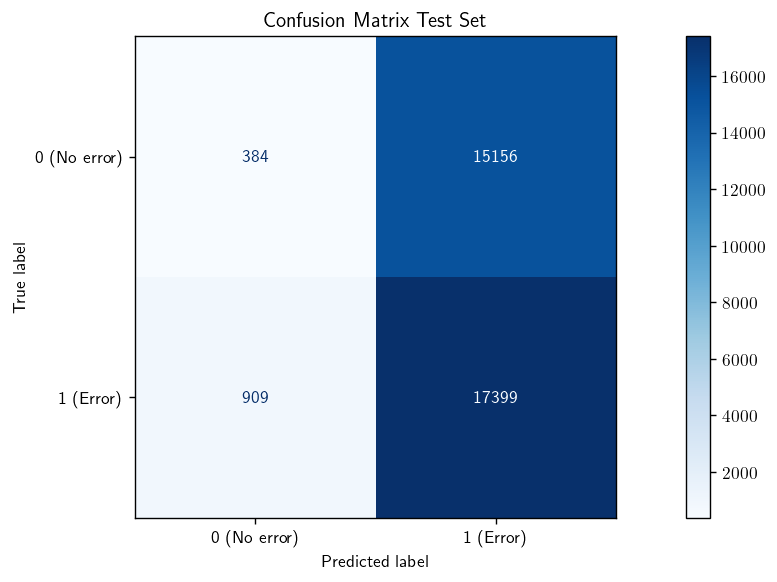

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(14.3, 5))
display_sklearn_reports(np.array(true_test), np.array(pred_test), train_or_val="Test", ax = ax)